### AMS 580 - Team Project 2 - Python - SVM

#### Eshan Shakrani, Vishnu Teja Sardee, Priyansh Desai, Mustafa Isik

Importing Necessary Libraries

In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import matplotlib.pyplot as plt

from sklearn.svm import SVC

### Problem 1

Read in + Clean the Data

In [3]:
# read in the data
df = pd.read_csv('../Data/Titanic.csv')

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
print("Original Columns:", df.columns.tolist())

# remove the "Name", "Ticket", and "Cabin" columns
df = df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis = 1)

print("After removing:", df.columns.tolist())

Original Columns: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
After removing: ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']


In [5]:
print(f"There were originally {len(df)} observations.")

# remove observations with missing values in the "Age" column
df = df.dropna(subset=['Age'])

print(f'After removing NA from "Age", there are {len(df)} observations left.')

There were originally 891 observations.
After removing NA from "Age", there are 714 observations left.


In [6]:
df.isna().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    2
dtype: int64

In [7]:
# there are still NA values in the "Embarked" column so remove those as well
df = df.dropna()

print(f'There are now {len(df)} observations left.')

There are now 712 observations left.


In [8]:
stats = df.describe()
stats

,Survived,Pclass,Age,SibSp,Parch,Fare
count,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000
mean,0.404494,2.240169,29.642093,0.514045,0.432584,34.567251
std,0.491139,0.836854,14.492933,0.930692,0.854181,52.938648
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,20.000000,0.000000,0.000000,8.050000
50%,0.000000,2.000000,28.000000,0.000000,0.000000,15.645850
75%,1.000000,3.000000,38.000000,1.000000,1.000000,33.000000
max,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


Data Standardization

In [9]:
# create a StandardScaler object 
ss = StandardScaler()

# fit the scaler to the "Age" and "Fare" columns and transform
df[['Age_Scaled', 'Fare_Scaled']] = ss.fit_transform(df[['Age', 'Fare']])

df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Age_Scaled,Fare_Scaled
0,0,3,male,22.0,1,0,7.2500,S,-0.527669,-0.516380
1,1,1,female,38.0,1,0,71.2833,C,0.577094,0.694046
2,1,3,female,26.0,0,0,7.9250,S,-0.251478,-0.503620
3,1,1,female,35.0,1,0,53.1000,S,0.369951,0.350326
4,0,3,male,35.0,0,0,8.0500,S,0.369951,-0.501257


In [10]:
# remove the original "Age" and "Fare" columns
df = df.drop(['Age', 'Fare'], axis = 1)

df.head()

,Survived,Pclass,Sex,SibSp,Parch,Embarked,Age_Scaled,Fare_Scaled
0,0,3,male,1,0,S,-0.527669,-0.516380
1,1,1,female,1,0,C,0.577094,0.694046
2,1,3,female,0,0,S,-0.251478,-0.503620
3,1,1,female,1,0,S,0.369951,0.350326
4,0,3,male,0,0,S,0.369951,-0.501257


In [11]:
print(f'There are currently {len(df)} passengers.')

There are currently 712 passengers.


Encoding Categorical Variables

In [12]:
# 'Embarked' and 'Parch' features are both categorical
df['Embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

In [13]:
df['Sex'].unique()

array(['male', 'female'], dtype=object)

In [14]:
# use a One Hot Encoder to encode the categorical features
ohe = OneHotEncoder(sparse=False)
transformed = ohe.fit_transform(df[['Sex', 'Embarked']])
features_transformed = ohe.get_feature_names_out()
features_transformed

array(['Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype=object)

In [15]:
# add the encoded features to the dataset
df[features_transformed] = transformed

In [16]:
df.head()

,Survived,Pclass,Sex,SibSp,Parch,Embarked,Age_Scaled,Fare_Scaled,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,male,1,0,S,-0.527669,-0.516380,0.0,1.0,0.0,0.0,1.0
1,1,1,female,1,0,C,0.577094,0.694046,1.0,0.0,1.0,0.0,0.0
2,1,3,female,0,0,S,-0.251478,-0.503620,1.0,0.0,0.0,0.0,1.0
3,1,1,female,1,0,S,0.369951,0.350326,1.0,0.0,0.0,0.0,1.0
4,0,3,male,0,0,S,0.369951,-0.501257,0.0,1.0,0.0,0.0,1.0


In [17]:
# drop the original 'Sex' and 'Embarked' columns
df = df.drop(['Sex', 'Embarked'], axis = 1)
df.head()

,Survived,Pclass,SibSp,Parch,Age_Scaled,Fare_Scaled,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,1,0,-0.527669,-0.516380,0.0,1.0,0.0,0.0,1.0
1,1,1,1,0,0.577094,0.694046,1.0,0.0,1.0,0.0,0.0
2,1,3,0,0,-0.251478,-0.503620,1.0,0.0,0.0,0.0,1.0
3,1,1,1,0,0.369951,0.350326,1.0,0.0,0.0,0.0,1.0
4,0,3,0,0,0.369951,-0.501257,0.0,1.0,0.0,0.0,1.0


Partitioning the Data

In [18]:
# split the data into features (X) and target (y)
X = df.drop('Survived', axis = 1)
y = df['Survived']

In [19]:
# split the data into 75% training and 25% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

### Problem 2

SVM with Linear Kernel

In [20]:
# SVM classifier with linear kernel and default cost "C"
svc2 = SVC(kernel='linear')

In [21]:
# train the SVC on the training data
svc2.fit(X_train, y_train)

SVC(kernel='linear')

In [22]:
# use the SVC to make predictions on the testing data
y_pred2 = svc2.predict(X_test)

Evaluate Performance

In [23]:
# generate the confusion matrix
cm2 = confusion_matrix(y_test, y_pred2, labels = svc2.classes_)
cm2

array([[89, 16],
       [29, 44]], dtype=int64)

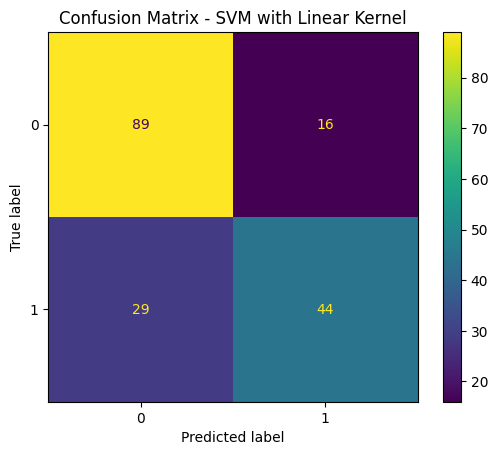

In [24]:
# better visualization of confusion matrix
disp_cm2 = ConfusionMatrixDisplay(cm2, display_labels=svc2.classes_)
disp_cm2.plot()
plt.title("Confusion Matrix - SVM with Linear Kernel")
plt.show()

In [25]:
# extract the elements of the confusion matrix
tn2, fp2, fn2, tp2 = cm2.ravel()

In [26]:
# Sensitivity
sens2 = tp2 / (tp2 + fn2)
print(f'The probability that a passenger who survived is predicted to have survived is {sens2:.4}')

The probability that a passenger who survived is predicted to have survived is 0.6027


In [29]:
# Specificity
spec2 = tn2 / (tn2 + fp2)
print(f'The probability that a passenger who did not survive is predicted to not have survived is {spec2:.4}')

The probability that a passenger who did not survive is predicted to not have survived is 0.8476


In [28]:
# Accuracy
acc2 = sum([tp2, tn2]) / sum([tn2, tp2, fn2, fp2])
print(f'The overall accuracy of the model is {acc2:.4}')

The overall accuracy of the model is 0.7472


NOTE: Adding the predictions for each model to the testing data at the end

### Problem 3

SVM with Linear Kernel

In [30]:
# SVM classifier with linear kernel
svc3 = SVC(kernel='linear')

In [41]:
# set up the Grid Search parameters
param_grid3 = {
    "C": np.linspace(0, 2, 20)
}

In [42]:
# perform the grid search
grid_search3 = GridSearchCV(svc3, param_grid=param_grid3, cv=5)
grid_search3.fit(X_train, y_train)

C:\Users\eshak\AppData\Roaming\Python\Python310\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\eshak\AppData\Roaming\Python\Python310\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\eshak\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py", line 251, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "C:\Users\eshak\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py", li

GridSearchCV(cv=5, estimator=SVC(kernel='linear'),
             param_grid={'C': array([0.        , 0.10526316, 0.21052632, 0.31578947, 0.42105263,
       0.52631579, 0.63157895, 0.73684211, 0.84210526, 0.94736842,
       1.05263158, 1.15789474, 1.26315789, 1.36842105, 1.47368421,
       1.57894737, 1.68421053, 1.78947368, 1.89473684, 2.        ])})

In [61]:
# get the optimal value of C from the GridSearch
optimal_C3 = grid_search3.best_params_["C"]
print(f"Optimal value for C: {optimal_C3:.4}")

Optimal value for C: 0.1053


In [44]:
# make the SVM classifier with Linear Kernel and the optimal C value
svc3_opt = SVC(kernel="linear", C=optimal_C3)

In [45]:
# train the SVC on the training data
svc3_opt.fit(X_train, y_train)

SVC(C=0.10526315789473684, kernel='linear')

In [51]:
# use the SVC to make predictions on the testing data
y_pred3 = svc3_opt.predict(X_test)

Evaluate Performance

In [52]:
# generate the confusion matrix
cm3 = confusion_matrix(y_test, y_pred3, labels = svc3_opt.classes_)
cm3

array([[89, 16],
       [29, 44]], dtype=int64)

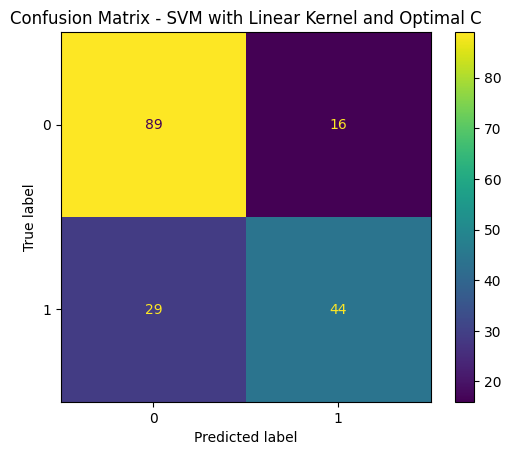

In [53]:
# better visualization of confusion matrix
disp_cm3 = ConfusionMatrixDisplay(cm3, display_labels=svc3_opt.classes_)
disp_cm3.plot()
plt.title("Confusion Matrix - SVM with Linear Kernel and Optimal C")
plt.show()

In [54]:
# extract the elements of the confusion matrix
tn3, fp3, fn3, tp3 = cm3.ravel()

In [55]:
# Sensitivity
sens3 = tp3 / (tp3 + fn3)
print(f'The probability that a passenger who survived is predicted to have survived is {sens3:.4}')

The probability that a passenger who survived is predicted to have survived is 0.6027


In [57]:
# Specificity
spec3 = tn3 / (tn3 + fp3)
print(f'The probability that a passenger who did not survive is predicted to not have survived is {spec3:.4}')

The probability that a passenger who did not survive is predicted to not have survived is 0.8476


In [58]:
# Accuracy
acc3 = sum([tp3, tn3]) / sum([tn3, tp3, fn3, fp3])
print(f'The overall accuracy of the model is {acc3:.4}')

The overall accuracy of the model is 0.7472


### Problem 4

SVM with Radial Basis Kernel

In [59]:
# SVM classifier with radial basis kernel
svc4 = SVC(kernel='rbf')

In [62]:
# set up the Grid Search parameters
param_grid4 = {
    "C": np.linspace(0, 2, 20),
    'gamma': np.linspace(0, 5, 20)
}

In [63]:
# perform the grid search
grid_search4 = GridSearchCV(svc4, param_grid=param_grid4, cv=5)
grid_search4.fit(X_train, y_train)

C:\Users\eshak\AppData\Roaming\Python\Python310\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
195 fits failed out of a total of 2000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\eshak\AppData\Roaming\Python\Python310\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\eshak\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py", line 237, in fit
    raise ValueError(msg)
ValueError: gamma value must be > 0; 0.0 is invalid. Use a positive number or use 'auto' to set gamma to a value of 1 / n_features.


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': array([0.        , 0.10526316, 0.21052632, 0.31578947, 0.42105263,
       0.52631579, 0.63157895, 0.73684211, 0.84210526, 0.94736842,
       1.05263158, 1.15789474, 1.26315789, 1.36842105, 1.47368421,
       1.57894737, 1.68421053, 1.78947368, 1.89473684, 2.        ]),
                         'gamma': array([0.        , 0.26315789, 0.52631579, 0.78947368, 1.05263158,
       1.31578947, 1.57894737, 1.84210526, 2.10526316, 2.36842105,
       2.63157895, 2.89473684, 3.15789474, 3.42105263, 3.68421053,
       3.94736842, 4.21052632, 4.47368421, 4.73684211, 5.        ])})

In [65]:
# get the optimal values of C and sigma from the GridSearch
optimal_C4, optimal_sigma4 = grid_search4.best_params_["C"], grid_search4.best_params_["gamma"]

print(f'Optimal value for C {optimal_C4:.4}')
print(f'Optimal value for sigma: {optimal_sigma4:.4}')

Optimal value for C 1.053
Optimal value for sigma: 0.2632


In [66]:
# make the SVM classifier with Radial Basis Kernel and the optimal values for C and sigma
svc4_opt = SVC(kernel="rbf", C=optimal_C4, gamma=optimal_sigma4)

In [67]:
# train the SVC on the training data
svc4_opt.fit(X_train, y_train)

SVC(C=1.0526315789473684, gamma=0.2631578947368421)

In [68]:
# use the SVC to make predictions on the testing data
y_pred4 = svc4_opt.predict(X_test)

Evaluate Performance

In [69]:
# generate the confusion matrix
cm4 = confusion_matrix(y_test, y_pred4, labels = svc4_opt.classes_)
cm4

array([[97,  8],
       [31, 42]], dtype=int64)

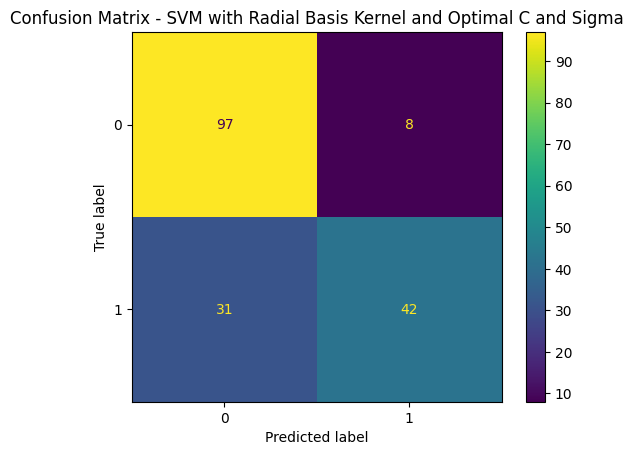

In [70]:
# better visualization of confusion matrix
disp_cm4 = ConfusionMatrixDisplay(cm4, display_labels=svc4_opt.classes_)
disp_cm4.plot()
plt.title("Confusion Matrix - SVM with Radial Basis Kernel and Optimal C and Sigma")
plt.show()

In [71]:
# extract the elements of the confusion matrix
tn4, fp4, fn4, tp4 = cm4.ravel()

In [72]:
# Sensitivity
sens4 = tp4 / (tp4 + fn4)
print(f'The probability that a passenger who survived is predicted to have survived is {sens4:.4}')

The probability that a passenger who survived is predicted to have survived is 0.5753


In [73]:
# Specificity
spec4 = tn4 / (tn4 + fp4)
print(f'The probability that a passenger who did not survive is predicted to not have survived is {spec4:.4}')

The probability that a passenger who did not survive is predicted to not have survived is 0.9238


In [74]:
# Accuracy
acc4 = sum([tp4, tn4]) / sum([tn4, tp4, fn4, fp4])
print(f'The overall accuracy of the model is {acc4:.4}')

The overall accuracy of the model is 0.7809


### Problem 5

SVM with Polynomial Kernel

In [75]:
# SVM classifier with polynomial kernel
svc5 = SVC(kernel='poly')

In [77]:
# set up the Grid Search parameters
param_grid5 = {
    "C": np.linspace(0, 2, 20),
    'degree': list(range(1,6)),
    'coef0': [-1, 0, 1]
}

In [78]:
# perform the grid search
grid_search5 = GridSearchCV(svc5, param_grid=param_grid5, cv=5)
grid_search5.fit(X_train, y_train)

C:\Users\eshak\AppData\Roaming\Python\Python310\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
75 fits failed out of a total of 1500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\eshak\AppData\Roaming\Python\Python310\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\eshak\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py", line 251, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "C:\Users\eshak\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py",

GridSearchCV(cv=5, estimator=SVC(kernel='poly'),
             param_grid={'C': array([0.        , 0.10526316, 0.21052632, 0.31578947, 0.42105263,
       0.52631579, 0.63157895, 0.73684211, 0.84210526, 0.94736842,
       1.05263158, 1.15789474, 1.26315789, 1.36842105, 1.47368421,
       1.57894737, 1.68421053, 1.78947368, 1.89473684, 2.        ]),
                         'coef0': [-1, 0, 1], 'degree': [1, 2, 3, 4, 5]})

In [81]:
# get the optimal values of C, degree, and scale from the GridSearch
optimal_C5, optimal_degree5, optimal_scale5 = grid_search5.best_params_["C"], grid_search5.best_params_["degree"], grid_search5.best_params_["coef0"]

print(f'Optimal value for C {optimal_C5:.4}')
print(f'Optimal value for degree: {optimal_degree5}')
print(f'Optimal value for scale: {optimal_scale5}')

Optimal value for C 1.158
Optimal value for degree: 3
Optimal value for scale: 0


In [82]:
# make the SVM classifier with Polynomial Kernel and the optimal values for C, degree, and scale
svc5_opt = SVC(kernel="poly", C=optimal_C5, degree=optimal_degree5, coef0=optimal_scale5)

In [83]:
# train the SVC on the training data
svc5_opt.fit(X_train, y_train)

SVC(C=1.1578947368421053, coef0=0, kernel='poly')

In [84]:
# use the SVC to make predictions on the testing data
y_pred5 = svc5_opt.predict(X_test)

Evaluate Performance

In [85]:
# generate the confusion matrix
cm5 = confusion_matrix(y_test, y_pred5, labels = svc5_opt.classes_)
cm5

array([[91, 14],
       [25, 48]], dtype=int64)

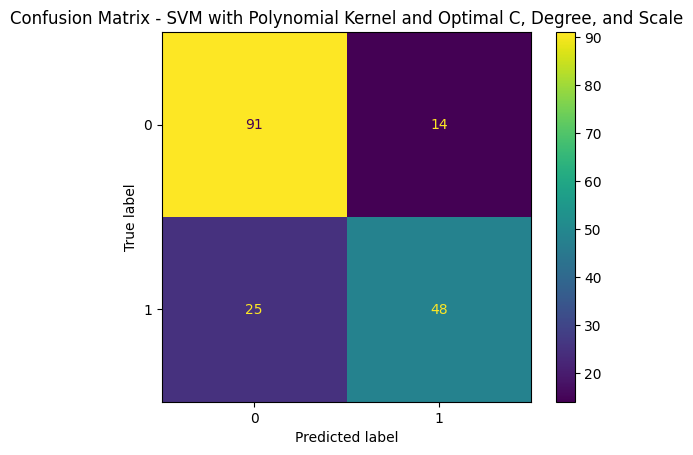

In [86]:
# better visualization of confusion matrix
disp_cm5 = ConfusionMatrixDisplay(cm5, display_labels=svc5_opt.classes_)
disp_cm5.plot()
plt.title("Confusion Matrix - SVM with Polynomial Kernel and Optimal C, Degree, and Scale")
plt.show()

In [87]:
# extract the elements of the confusion matrix
tn5, fp5, fn5, tp5 = cm5.ravel()

In [88]:
# Sensitivity
sens5 = tp5 / (tp5 + fn5)
print(f'The probability that a passenger who survived is predicted to have survived is {sens5:.4}')

The probability that a passenger who survived is predicted to have survived is 0.6575


In [89]:
# Specificity
spec5 = tn5 / (tn5 + fp5)
print(f'The probability that a passenger who did not survive is predicted to not have survived is {spec5:.4}')

The probability that a passenger who did not survive is predicted to not have survived is 0.8667


In [90]:
# Accuracy
acc5 = sum([tp5, tn5]) / sum([tn5, tp5, fn5, fp5])
print(f'The overall accuracy of the model is {acc5:.4}')

The overall accuracy of the model is 0.7809


Adding the predictions from Problem 2 to the testing data

In [112]:
y_test_df = pd.DataFrame(y_test)

In [115]:
y_test_df['Problem 2 Predictions'] = y_pred2

In [116]:
y_test_df

,Survived,Problem 2 Predictions
509,1,0
640,0,0
537,1,1
526,1,1
262,0,0
...,...,...
741,0,0
562,0,0
586,0,0
88,1,1


### Problem 6

Find the model with the best accuracy

In [119]:
# acc3: Linear with optimal C
# acc4: Radial with optimal C and sigma
# acc5: Polynomial with optimal C, degree, and scale
accuracies = [acc3, acc4, acc5]

models = ['Linear SVM', 'SVM with Radial Basis Kernel', 'SVM with Polynomial Kernel']

# get the highest accuracy of the three
max_accuracy = max(accuracies)

# get the highest accuracy's index
max_index = accuracies.index(max_accuracy)

# get the highest accuracy's corresponding model
best_model = models[max_index]

print(f'Best model was {best_model} with an accuracy of {max_accuracy:.4}')


Best model was SVM with Radial Basis Kernel with an accuracy of 0.7809
